# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [15]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [16]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [17]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.initializers.GlorotUniform()(shape=[in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation == "relu":
            return tf.nn.relu(y)
        elif activation == "softmax":
            return tf.nn.softmax(y)
        else:
            return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        x = self.layer_1(x, activation="relu")
        x = self.layer_2(x, activation="relu")
        x = self.out_layer(x, activation="softmax")
        return x



In [18]:

# Ініціалізуємо модель
neural_net = NN(name="mnist")

# Визначимо функцію втрат
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Оптимізатор Adam
optimizer = tf.optimizers.Adam(learning_rate)



In [19]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

# Тренувальний цикл
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")



Step: 100, Loss: 0.19977755844593048, Accuracy: 0.953125
Step: 200, Loss: 0.22803081572055817, Accuracy: 0.9296875
Step: 300, Loss: 0.21338127553462982, Accuracy: 0.9296875
Step: 400, Loss: 0.09780779480934143, Accuracy: 0.9765625
Step: 500, Loss: 0.14458373188972473, Accuracy: 0.96484375
Step: 600, Loss: 0.06851322203874588, Accuracy: 0.9765625
Step: 700, Loss: 0.11074299365282059, Accuracy: 0.9609375
Step: 800, Loss: 0.09232303500175476, Accuracy: 0.98046875
Step: 900, Loss: 0.11109457910060883, Accuracy: 0.96875
Step: 1000, Loss: 0.09490105509757996, Accuracy: 0.9765625
Step: 1100, Loss: 0.04450426995754242, Accuracy: 0.99609375
Step: 1200, Loss: 0.027937889099121094, Accuracy: 0.9921875
Step: 1300, Loss: 0.05395352840423584, Accuracy: 0.984375
Step: 1400, Loss: 0.058590542525053024, Accuracy: 0.98828125
Step: 1500, Loss: 0.03755762428045273, Accuracy: 0.9921875
Step: 1600, Loss: 0.031076500192284584, Accuracy: 0.9921875
Step: 1700, Loss: 0.019225776195526123, Accuracy: 0.9921875
St

In [20]:

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_acc = tf.keras.metrics.Accuracy()

In [21]:

# Тестування моделі
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_acc = tf.keras.metrics.Accuracy()

for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    test_acc.update_state(tf.argmax(pred, 1), batch_y)

print(f"Test Accuracy: {test_acc.result().numpy()}")

Test Accuracy: 0.9779000282287598


Step: 100, Loss: 0.0025330763310194016, Accuracy: 1.0
Step: 200, Loss: 0.007915018126368523, Accuracy: 1.0
Step: 300, Loss: 0.02082640677690506, Accuracy: 0.99609375
Step: 400, Loss: 0.008902831003069878, Accuracy: 1.0
Step: 500, Loss: 0.024506602436304092, Accuracy: 0.99609375
Step: 600, Loss: 0.0029998403042554855, Accuracy: 1.0
Step: 700, Loss: 0.009410908445715904, Accuracy: 1.0
Step: 800, Loss: 0.004640105180442333, Accuracy: 1.0
Step: 900, Loss: 0.02426294796168804, Accuracy: 0.9921875
Step: 1000, Loss: 0.018108023330569267, Accuracy: 1.0
Step: 1100, Loss: 0.002969516674056649, Accuracy: 1.0
Step: 1200, Loss: 0.004530108533799648, Accuracy: 1.0
Step: 1300, Loss: 0.001606968231499195, Accuracy: 1.0
Step: 1400, Loss: 0.0014200215227901936, Accuracy: 1.0
Step: 1500, Loss: 0.008805635385215282, Accuracy: 1.0
Step: 1600, Loss: 0.0025199889205396175, Accuracy: 1.0
Step: 1700, Loss: 0.0034521776251494884, Accuracy: 1.0
Step: 1800, Loss: 0.007591024041175842, Accuracy: 1.0
Step: 1900, Lo

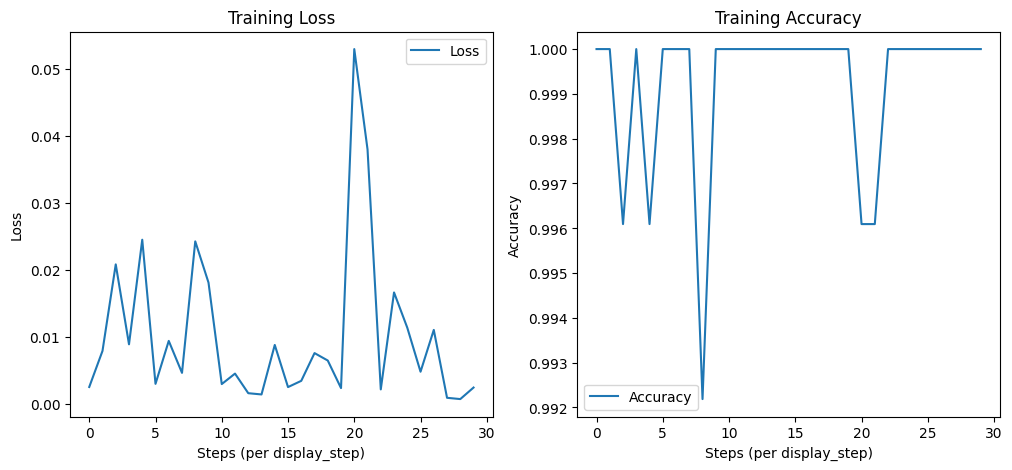

In [22]:
# Виведіть графік функції втрат

loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history, label='Loss')
plt.xlabel('Steps (per display_step)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history)), accuracy_history, label='Accuracy')
plt.xlabel('Steps (per display_step)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [23]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_acc = tf.keras.metrics.Accuracy()

for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    test_acc.update_state(tf.argmax(pred, 1), batch_y)

print(f"Test Accuracy: {test_acc.result().numpy()}")

Test Accuracy: 0.9805999994277954


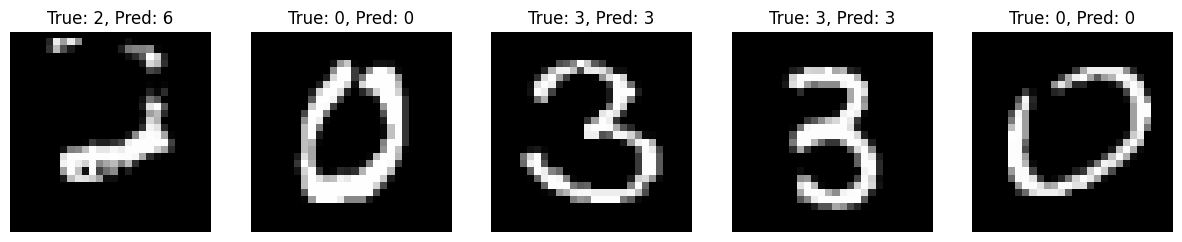

In [24]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду

indices = np.random.choice(len(x_test), 5)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# Перетворюємо зображення для нейронної мережі
sample_images_reshaped = sample_images.reshape([-1, num_features])

# Отримуємо передбачення
predictions = neural_net(sample_images_reshaped)

# Виведемо зображення та передбачення
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}, Pred: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()


Test Accuracy: 0.9805999994277954


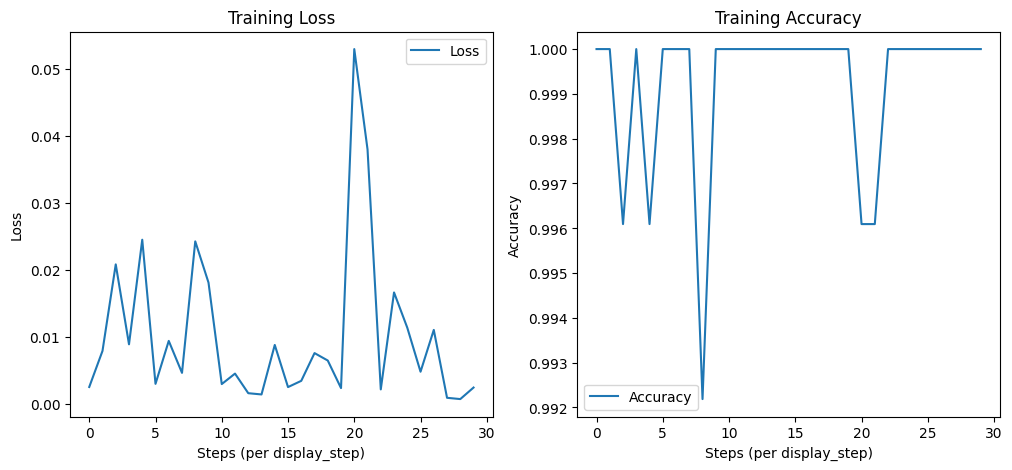

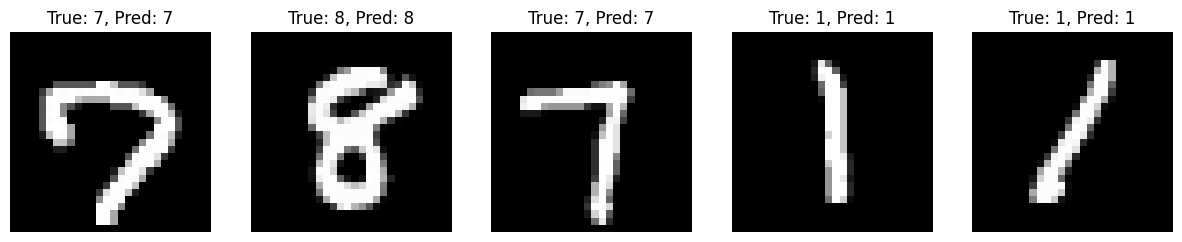

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [25]:


all_predictions = []
all_labels = []

for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    all_predictions.extend(tf.argmax(pred, 1).numpy())
    all_labels.extend(batch_y.numpy())
    test_acc.update_state(tf.argmax(pred, 1), batch_y)

print(f"Test Accuracy: {test_acc.result().numpy()}")

# Виведіть графік функції втрат
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history, label='Loss')
plt.xlabel('Steps (per display_step)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history)), accuracy_history, label='Accuracy')
plt.xlabel('Steps (per display_step)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

# Протестуйте навчену нейромережу на 5 зображеннях
indices = np.random.choice(len(x_test), 5)
sample_images = x_test[indices]
sample_labels = y_test[indices]

sample_images_reshaped = sample_images.reshape([-1, num_features])
predictions = neural_net(sample_images_reshaped)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}, Pred: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()

# Виведення метрик якості для кожного класу
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(num_classes)]))
